In [140]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import average_precision_score
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/SupervisedLearning/scripts/")

In [141]:
from util import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in Data 

In [3]:
train = pd.read_csv("../../AnomalyDetection/processedData/TrainingData_normal.csv")
dev = pd.read_csv("../../AnomalyDetection/processedData/DevData_normal.csv")
test = pd.read_csv("../../AnomalyDetection/processedData/hold_outset_moreFraud.csv")

In [4]:
training,testing = train_test_dfs(train,dev,test,"Class",0.1,2020)

In [5]:
train_X, train_y = training.drop("Class", axis=1), training.Class;
test_X, test_y = testing.drop("Class",axis=1), testing.Class;

### XGBoost Parameters
   * Key tree booster parameters:
      * eta (learning rate) 
      * gamma: min loss reduction required to make a further split 
      * max depth: high deep the tree will be. Also memory costly.
      * min_child_weight: decides on complex the model will be. 
      * max_delta_step: might help with logistic regression when class is extremely imbalanced.
      * subsample: sample only parts of the data to prevent overfitting. 
      * sampling_method: 
         * uniform: subsample >= 0.5 is great. most tree methods only support this. 
         * gradient_based: subsample can be set to 0.1 and be okay. tree_method is = gpu_hist;
      * colsample_bytree, colsample_bylevel, colsample_bynode: subsmapling of feature columns. 
      * lambda: l1 regularization. 
      * alpha: l1. 
      * tree method: auto,exact,approx,hist,gpu_hist (approx,hist,gpu_hist for distributed training) 
      * scale_pos_weight: control balance of positive and negative weights, start (sum(negative)/sum(positive))
      * updater: define the sequence of tree updaters to run. 
      * refresh_leaf: when refresh in updater is 1, the tree leafs and nodes stats are updated if 0 only node stats are updated.
      * process_type: a type of boosting process to run
         * default: creates new trees 
         * update: only updates trees. 
      * num_parallel_tree: default is 1, num of parallel trees constructed during each iteration. It allows boosted random forest. 
      * 

### run a model with default parameter first

In [6]:
default_mdl = XGBClassifier().fit(train_X, train_y, eval_metric="aucpr")

In [7]:
pred_score_default = default_mdl.predict_proba(test_X)

In [118]:
output = model_results(test_y,pred_score_default[:,1],0.5, ifprint=True)
print(f"Default precision recall AUC is {precision_score(test_y,default_mdl.predict(test_X))}")

[[28436     5]
 [   10    30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28441
           1       0.86      0.75      0.80        40

    accuracy                           1.00     28481
   macro avg       0.93      0.87      0.90     28481
weighted avg       1.00      1.00      1.00     28481

Default precision recall AUC is 0.8571428571428571


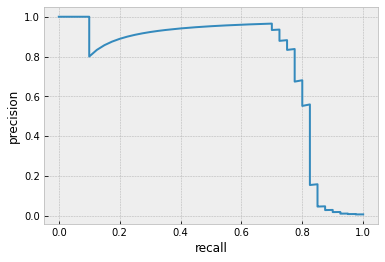

In [142]:
plot_pr_re(test_y,pred_score_default[:,1])

### Really good initial results and let's see if we can improve this

### Define Custom Metrics and run gridsearchCV

In [9]:
XG_model = XGBClassifier()

In [10]:
custom_metrics = make_custom_score()

In [11]:
parameters = {
    "eta":[0.05,0.1,0.5],
    "max_depth":[3,5,7],
    "n_estimators":[20,50,100]
    }

In [12]:
searchCV = GridSearchCV(XG_model,
                        parameters,
                        verbose=1,
                        scoring=custom_metrics,
                        refit=False,
                        cv=5,
                        n_jobs=20)                   

In [13]:
searchCV.fit(train_X, train_y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   15.2s
[Parallel(n_jobs=20)]: Done 135 out of 135 | elapsed:  4.0min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=20,
             param_grid={'eta': [0.05, 0.1, 0.5]

In [14]:
CVResultsOutput(searchCV.cv_results_,custom_metrics.keys()).sort_values("tp",ascending=False)

,eta,max_depth,n_estimators,tp,fp,fn,f1_f,prec_f,recall_f
25,0.50,7,50,72.4,3.6,18.0,0.869525,0.953249,0.800952
14,0.10,5,100,72.4,4.6,18.0,0.864754,0.940519,0.801001
13,0.10,5,50,72.2,4.2,18.2,0.865494,0.945333,0.798779
12,0.10,5,20,72.0,5.4,18.4,0.858053,0.930717,0.796532
4,0.05,5,50,72.0,5.4,18.4,0.858053,0.930717,0.796532
5,0.05,5,100,72.0,4.2,18.4,0.864187,0.945179,0.796557
18,0.50,3,20,72.0,6.2,18.4,0.853731,0.921084,0.796532
7,0.05,7,50,72.0,4.8,18.4,0.861042,0.938583,0.796532
24,0.50,7,20,71.8,4.4,18.6,0.861435,0.943087,0.794310
17,0.10,7,100,71.8,4.0,18.6,0.863775,0.947637,0.794335


### the following parameter seems to provide the best metrics:
  * eta: 0.5
  * maxdepth:7
  * n_estimators: 50
  

In [15]:
best_model = XGBClassifier(n_estimators=50, eta = 0.5, max_depth=7).fit(train_X,train_y)

In [16]:
best_pred_score = best_model.predict_proba(test_X)

In [57]:
y_pred = best_model.predict(test_X)

In [120]:
final_output = model_results(test_y,best_pred_score[:,1],0.5,True)
print(f"Tuned precision recall AUC is {precision_score(test_y,y_pred)}")

[[28438     3]
 [   10    30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28441
           1       0.91      0.75      0.82        40

    accuracy                           1.00     28481
   macro avg       0.95      0.87      0.91     28481
weighted avg       1.00      1.00      1.00     28481

Tuned precision recall AUC is 0.9090909090909091


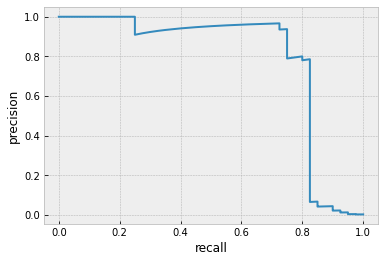

In [143]:
plot_pr_re(test_y,best_pred_score[:,1])

### Precision has been improved after rough gridsearchCV

### Let's try to see if a semi recursive feature elimination would improve recall and f1 score

### Importance by average purity gain of splits 

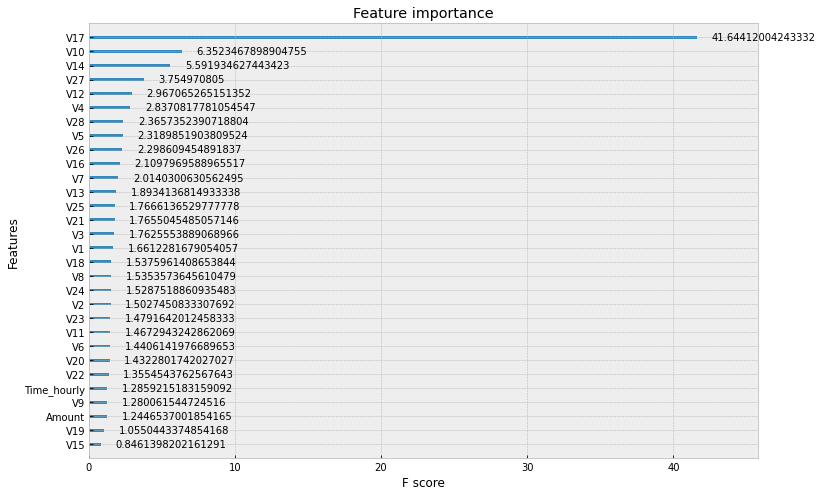

In [53]:
plt.rcParams["figure.figsize"]=(12,8)
xgboost.plot_importance(best_model, importance_type="gain")
plt.show()

### Importance by weight (num of times a feature appears in a tree)

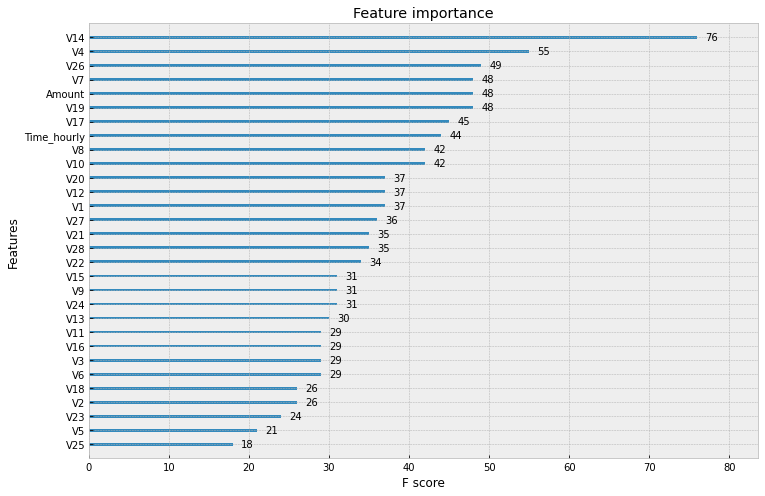

In [54]:
plt, ax1 = plt.subplots(figsize=(12,8))
xgboost.plot_importance(best_model, ax=ax1)
plt.show()

### Importance by cover (num of samples affected by a split when split by the feature)

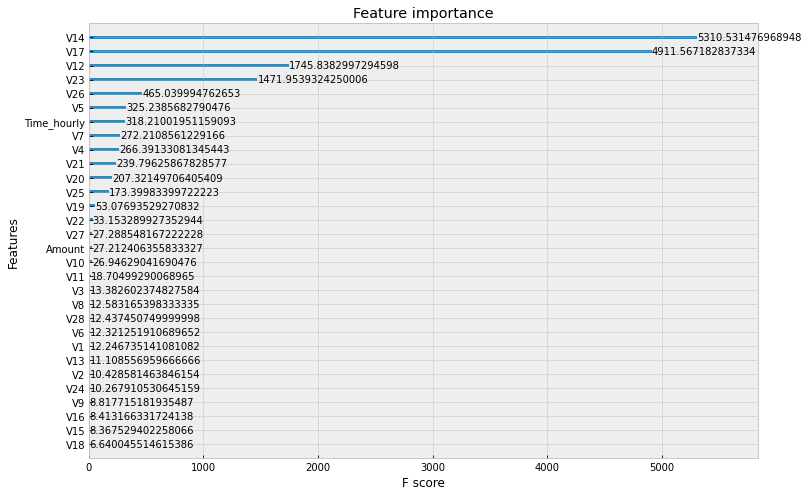

In [55]:
xgboost.plot_importance(best_model,importance_type="cover")
plt.show()

In [96]:
df_weight = pd.DataFrame({"features":test_X.columns, "score": best_model.feature_importances_}).sort_values("score",ascending=False)

### As you can see based upon the criteria, you can get different ranking of features and makes it very difficult to remove features based upon a specific ranking type

### Check out various features from 25 to 10 in increment of -5 and just randomly remove 5 features at a time and get best pr_recall auc score

In [126]:
metrics = []
features = []
num_features =[]
for n in np.arange(25,5,-5):
    print(n)
    best_metric, best_features = customFeatureElimination(train_X,train_y,
                                                    test_X,test_y,
                                                    n,max_iter=50,delta=10,verbose=False)
    num_features.append(n)
    metrics.append(best_metric)
    features.append(best_features)
final_result = pd.DataFrame({"n_features":num_features,
              "metrics":metrics,
              "features":features})

In [91]:
final_result

,n_features,metrics,features
0,25,0.937500,"Index(['V16', 'V3', 'V21', 'V8', 'V25', 'V9', ..."
1,20,0.937500,"Index(['V23', 'V6', 'V4', 'V19', 'V8', 'V15', ..."
2,15,0.939394,"Index(['V28', 'Amount', 'V16', 'V3', 'V10', 'V..."
3,10,0.931034,"Index(['V10', 'V22', 'V3', 'V23', 'V24', 'V6',..."


### Apparently with roughly 15 features we can get the highest pr_recall auc 

In [108]:
best_features = final_result["features"].iloc[2]

In [109]:
best_features

Index(['V28', 'Amount', 'V16', 'V3', 'V10', 'V4', 'V8', 'V14', 'V6', 'V13',
       'V18', 'V27', 'V7', 'Time_hourly', 'V23'],
      dtype='object')

### How does it compare with tree model feature importance by weight, cover, and gain?
  * If you use any of the three criteria, this combination would never been compiled as the way tree model works can be highly dependent upon the entire composition of features and when the features get to split first depend upon seeding

In [112]:
final_model = XGBClassifier(n_estimators=50, eta = 0.25, max_depth=5).fit(train_X[best_features], train_y, eval_metric="aucpr")

In [113]:
final_pred_score = final_model.predict_proba(test_X[best_features])

In [121]:
final_output = model_results(test_y,final_pred_score[:,1],0.5,True)
print(f"15 feature precision recall AUC is {precision_score(test_y,final_model.predict(test_X[best_features]))}")

[[28439     2]
 [    9    31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28441
           1       0.94      0.78      0.85        40

    accuracy                           1.00     28481
   macro avg       0.97      0.89      0.92     28481
weighted avg       1.00      1.00      1.00     28481

15 feature precision recall AUC is 0.9393939393939394


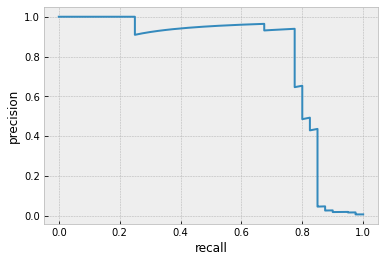

In [144]:
plot_pr_re(test_y,final_model.predict_proba(test_X[best_features])[:,1])